<a href="https://colab.research.google.com/github/ahujaravinder022/AzureDeployment/blob/master/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLAMA3 Fine-tuning for text classification using QLORA


### Requirements:
* A GPU with enough memory!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

In [1]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 

### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Sentiment Analysis Classification:


#### 1. Text Generation with Sentiment Label as part of text
- **Approach**: Train the model to generate text that naturally appends the sentiment label at the end.
- **Input**: "TSLA slashes model Y prices ======"
- **Output**: "TSLA slashes model Y prices ====== Bearish"
- **Use Case**: This method is useful for applications requiring continuous text output that includes embedded sentiment analysis, such as interactive chatbots or automated content creation tools.


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "TSLA slashes Model Y prices").
- **Output**: Direct sentiment classification (e.g., "Bearish").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


###### Imports

In [6]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


### Youtube Video Describing How to get Dataset
* Only really need first 3 mins of video

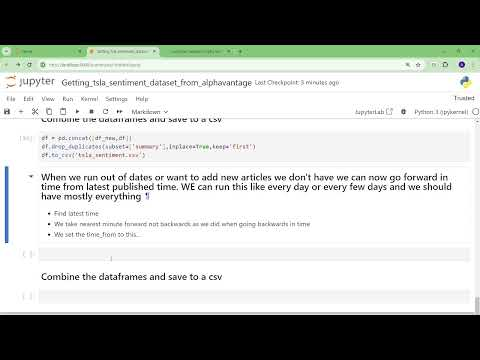

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ascf3y7zSaY')

#### Load TSLA sentiment analysis dataset
* Derived from Alpha vantage text data...


In [7]:
df = pd.read_csv("/content/tsla_sentiment (1).csv")
df

,time_published,title,url,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment,ticker_relevance_TSLA,ticker_sentiment_TSLA,num_tickers,detailed_original_label,label
0,20230829T142600,Is Tesla Stock on Its Way Back to $300?,https://www.fool.com/investing/2023/08/29/is-t...,['Howard Smith'],The electric vehicle leader's long-term strate...,https://g.foolcdn.com/image/?url=https%3A%2F%2...,Motley Fool,NaN,www.fool.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",0.238759,Somewhat-Bullish,"[{'ticker': 'TSLA', 'relevance_score': '0.5605...",0.560594,0.352957,1,Bullish,Bullish
1,20230829T150500,Is Tesla Gearing Up to Tap India's EV Market? ...,https://www.zacks.com/stock/news/2141965/is-te...,['Yashwardhan Jain'],Could a change in the Indian government's EV m...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,NaN,www.zacks.com,"[{'topic': 'Financial Markets', 'relevance_sco...",0.228988,Somewhat-Bullish,"[{'ticker': 'TSLA', 'relevance_score': '0.4111...",0.411176,0.271912,1,Somewhat_Bullish,Bullish
2,20230829T163722,Why Tesla Stock Is Moving Higher Today - Tesla...,https://www.benzinga.com/news/23/08/34095795/w...,['Erica Kollmann'],"Tesla, Inc. TSLA shares are trading higher ami...",https://cdn.benzinga.com/files/images/story/20...,Benzinga,News,www.benzinga.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",0.253732,Somewhat-Bullish,"[{'ticker': 'TSLA', 'relevance_score': '0.9565...",0.956537,0.641150,1,Bullish,Bullish
3,20230829T184158,Why Tesla Stock Jumped Today,https://www.fool.com/investing/2023/08/29/why-...,['Howard Smith'],Good news for BYD is also really good news for...,https://g.foolcdn.com/image/?url=https%3A%2F%2...,Motley Fool,NaN,www.fool.com,"[{'topic': 'Manufacturing', 'relevance_score':...",0.410442,Bullish,"[{'ticker': 'TSLA', 'relevance_score': '0.8555...",0.855561,0.687331,1,Bullish,Bullish
4,20230829T184700,U.S. regulator asks for information on Tesla A...,https://www.reuters.com/business/autos-transpo...,['Hyunjoo Jin'],A Tesla Model 3 vehicle drives on autopilot al...,https://cloudfront-us-east-2.images.arcpublish...,Reuters,Business,www.reuters.com,"[{'topic': 'Manufacturing', 'relevance_score':...",0.111297,Neutral,"[{'ticker': 'TSLA', 'relevance_score': '0.9003...",0.900307,0.166671,1,Somewhat_Bullish,Bullish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,20240726T121000,Is Tesla Stock an Excellent Investment?,https://www.fool.com/investing/2024/07/26/is-t...,"['Parkev Tatevosian', 'CFA']",Tesla's stock price fell by more than 10% foll...,https://g.foolcdn.com/editorial/images/784684/...,Motley Fool,NaN,www.fool.com,"[{'topic': 'Earnings', 'relevance_score': '0.3...",-0.230686,Somewhat-Bearish,"[{'ticker': 'TSLA', 'relevance_score': '0.7636...",0.763670,-0.418808,1,Bearish,Bearish
2438,20240726T141401,Tesla Stock Approaches Golden Cross: Is EV Sto...,https://www.benzinga.com/trading-ideas/technic...,['Surbhi Jain'],Tesla Inc. TSLA has been in the spotlight rece...,https://editorial-assets.benzinga.com/wp-conte...,Benzinga,Trading,www.benzinga.com,"[{'topic': 'Earnings', 'relevance_score': '0.6...",0.231011,Somewhat-Bullish,"[{'ticker': 'TSLA', 'relevance_score': '0.5621...",0.562170,0.172876,1,Somewhat_Bullish,Bullish
2439,20240726T164124,SHAREHOLDER ALERT: Pomerantz Law Firm Investig...,https://www.benzinga.com/pressreleases/24/07/g...,['Globe Newswire'],"NEW YORK, July 26, 2024 ( GLOBE NEWSWIRE ) -- ...",https://www.benzinga.com/next-assets/images/sc...,Benzinga,News,www.benzinga.com,"[{'topic': 'Earnings', 'relevance_score': '0.7...",0.097318,Neutral,"[{'ticker': 'TSLA', 'relevance_score': '0.5888...",0.588876,0.109881,1,Neutral,Neutral
2440,20240727T140300,No One Really Knows What Tesla Stock Is Worth,https://www.fool.com/investing/2024/07/27/no-o...,['Daniel Sparks'],Is it right that the stock is not worth buying?,https://g.foolcdn.com/editorial

In [9]:
df=df[['time_published','summary','label']]
df.head()

,time_published,summary,label
0,20230829T142600,The electric vehicle leader's long-term strate...,Bullish
1,20230829T150500,Could a change in the Indian government's EV m...,Bullish
2,20230829T163722,"Tesla, Inc. TSLA shares are trading higher ami...",Bullish
3,20230829T184158,Good news for BYD is also really good news for...,Bullish
4,20230829T184700,A Tesla Model 3 vehicle drives on autopilot al...,Bullish


In [8]:
#df.columns

Index(['time_published', 'title', 'url', 'authors', 'summary', 'banner_image',
       'source', 'category_within_source', 'source_domain', 'topics',
       'overall_sentiment_score', 'overall_sentiment_label',
       'ticker_sentiment', 'ticker_relevance_TSLA', 'ticker_sentiment_TSLA',
       'num_tickers', 'detailed_original_label', 'label'],
      dtype='object')

* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [10]:
df['label']=df['label'].astype('category')
df['target']=df['label'].cat.codes

df.head()

<ipython-input-10-ed8e26c15b74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['label'].astype('category')
<ipython-input-10-ed8e26c15b74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target']=df['label'].cat.codes


,time_published,summary,label,target
0,20230829T142600,The electric vehicle leader's long-term strate...,Bullish,1
1,20230829T150500,Could a change in the Indian government's EV m...,Bullish,1
2,20230829T163722,"Tesla, Inc. TSLA shares are trading higher ami...",Bullish,1
3,20230829T184158,Good news for BYD is also really good news for...,Bullish,1
4,20230829T184700,A Tesla Model 3 vehicle drives on autopilot al...,Bullish,1


* Suppose you want to decode later

In [11]:
df['label'].cat.categories

Index(['Bearish', 'Bullish', 'Neutral'], dtype='object')

In [12]:
category_map = {code: category for code, category in enumerate(df['label'].cat.categories)}
category_map

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

### Split into train/val/test for later comparison.
* For simplicity we split based on time.
  - First 60% train
  - Next 20% val
  - Next 20% test
* This can be problematic a bit since class balance changes over time and some articles on boundries between train/val or val/test have some overlap, but completely beats bias of stratified sample usually used since some articles are literally on same thing, but maybe different sources.


In [13]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(1465, 4) (489, 4) (488, 4)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [16]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [17]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility


In [18]:
dataset_train

Dataset({
    features: ['time_published', 'summary', 'target'],
    num_rows: 1465
})

In [19]:
dataset_val

Dataset({
    features: ['time_published', 'summary', 'target'],
    num_rows: 488
})

In [20]:
dataset_test

Dataset({
    features: ['time_published', 'summary', 'target'],
    num_rows: 489
})

In [21]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 1465
    })
    val: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 488
    })
    test: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 489
    })
})

In [22]:
dataset['train']

Dataset({
    features: ['time_published', 'summary', 'target'],
    num_rows: 1465
})

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [23]:
df_train.target.value_counts(normalize=True)

,proportion
target,
2,0.456655
1,0.395222
0,0.148123


In [24]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.5885, 0.2206, 0.1909])

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

In [25]:
model_name = "meta-llama/Meta-Llama-3-8B"

#### Quantization Config (for QLORA)

In [26]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [27]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=3
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* prepare_model_for_kbit_training() function to preprocess the quantized model for training.

In [29]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [30]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

In [33]:
model.print_trainable_parameters()

trainable params: 13,643,776 || all params: 7,518,580,736 || trainable%: 0.181467440186839


### Load the tokenizer

#### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [34]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

In [35]:
sentences = df_test.summary.tolist()
sentences[0:2]

['I recently rented a Tesla from Hertz, for an experience that tried to be wonderful but failed. Hertz purchased a very large number of Teslas, but got poor response from customers, and so has put many of them on sale. Going through the experience myself, I learned more about what they are doing ...',
 'Tesla Model Y owners can pay to unlock more range, Elon Musk says - Business Insider ...']

In [36]:
# Convert summaries to a list
sentences = df_test.summary.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



In [38]:
all_outputs

[tensor([[ 1.9175,  1.8649, -5.5886],
         [ 0.0418, -1.3881, -0.5462],
         [-0.3205, -0.7623, -2.6625],
         [ 2.6321,  0.5403, -6.3897],
         [ 1.3887, -1.9812,  0.9942],
         [ 0.1513,  0.2602, -3.9308],
         [-0.8422, -0.6474,  0.0307],
         [-1.6228,  2.1384, -2.9092],
         [ 0.8606,  6.6384, -1.8228],
         [ 1.1684,  1.2516, -0.2344],
         [ 4.9111,  1.9560, -3.0734],
         [ 0.1842,  1.8799, -3.2999],
         [ 0.4929,  1.0860, -2.0848],
         [-4.1021,  1.3711, -4.1066],
         [-0.4622, -2.2094, -0.3086],
         [ 2.4249, -1.5720, -5.1269],
         [-0.7145, -0.9062, -1.8203],
         [ 2.1325, -3.0759, -4.7046],
         [-0.4115,  0.2259,  1.9109],
         [ 1.8727, -2.3728, -4.3580],
         [-2.7360,  0.2074, -2.5413],
         [ 3.1815, -1.7947, -5.1580],
         [-0.8995, -0.4350, -2.4899],
         [ 1.5087, -0.9353,  0.5602],
         [-0.7891,  0.2862, -1.9395],
         [ 1.9733, -0.3854, -3.5194],
         [ 1

* Concatenate all outputs into a single tensor

In [39]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 1.9175,  1.8649, -5.5886],
        [ 0.0418, -1.3881, -0.5462],
        [-0.3205, -0.7623, -2.6625],
        ...,
        [-1.3016,  5.5424, -4.0772],
        [-3.5332,  1.4488, -0.1068],
        [ 2.4338, -0.4430, -3.8598]], device='cuda:0')

* argmax to get class prediction

In [40]:
final_outputs.argmax(axis=1)

tensor([0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 2, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2,
        1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0,
        0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1,

* Move to CPU so we can use numpy and set prediction colum to it

In [41]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

<ipython-input-41-7c1d2547ae19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


,predictions
1953,0
1954,0
1955,0
1956,0
1957,0
1958,1
1959,2
1960,1
1961,1
1962,1


In [42]:
df_test['predictions'].value_counts()

,count
predictions,
0,291
1,144
2,54


#### Use category map to get back category names

In [43]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

<ipython-input-43-b56fb9d5a919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


,predictions
1953,Bearish
1954,Bearish
1955,Bearish
1956,Bearish
1957,Bearish
1958,Bullish
1959,Neutral
1960,Bullish
1961,Bullish
1962,Bullish


### Analyze performance as in intro notebook

In [44]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [45]:
get_performance_metrics(df_test)

Confusion Matrix:
[[ 41  22   4]
 [114  66  22]
 [136  56  28]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.14      0.61      0.23        67
     Bullish       0.46      0.33      0.38       202
     Neutral       0.52      0.13      0.20       220

    accuracy                           0.28       489
   macro avg       0.37      0.36      0.27       489
weighted avg       0.44      0.28      0.28       489

Balanced Accuracy Score: 0.3553152330158389
Accuracy Score: 0.27607361963190186


# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [46]:
MAX_LEN = 512
col_to_delete = ['time_published', 'summary']

def llama_preprocessing_function(examples):
    return tokenizer(examples['summary'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/1465 [00:00<?, ? examples/s]

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [47]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


# define which metrics to compute for evaluation
* We will use balanced accuracy and accuracy for simplicity

In [48]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}



### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [50]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


# define training args

In [51]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

#### Define custom trainer

In [52]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

<ipython-input-50-1bea759fa04e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


* https://huggingface.co/docs/transformers/en/training

### Run trainer!

In [53]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,No log,1.299916,0.437749,0.446721
2,No log,1.215914,0.438549,0.442623


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


#### Let's check the results
* I wrapped in a function

In [54]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.summary.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

<ipython-input-54-0a3ae9ffca54>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
<ipython-input-54-0a3ae9ffca54>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


In [55]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.summary.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

<ipython-input-55-0a3ae9ffca54>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
<ipython-input-55-0a3ae9ffca54>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


In [56]:
get_performance_metrics(df_test)

Confusion Matrix:
[[ 41   6  20]
 [ 29 122  51]
 [ 56  78  86]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.33      0.61      0.42        67
     Bullish       0.59      0.60      0.60       202
     Neutral       0.55      0.39      0.46       220

    accuracy                           0.51       489
   macro avg       0.49      0.54      0.49       489
weighted avg       0.54      0.51      0.51       489

Balanced Accuracy Score: 0.5356032618187191
Accuracy Score: 0.50920245398773


### Saving the model trainer state and model adapters

In [57]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        2.0
  total_flos               =  7598013GF
  train_loss               =     1.2342
  train_runtime            = 0:26:05.88
  train_samples            =       1465
  train_samples_per_second =      1.871
  train_steps_per_second   =      0.235


#### Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [58]:
trainer.save_model("saved_model")

### Inference from Saved Model

In [59]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: mount failed

In [ ]:
!cp -r sentiment_classification /content/drive/MyDrive/

In [ ]:
!cp -r saved_model /content/drive/MyDrive/